# Least Square DCGAN

In the previous notebook, we saw that DCGAN generates images similar to MNIST. However, I was not very impressed with the generated images. One of the reason was that most of the generated images looks similar to the digit $1$. Some of the digits cannot be recognized properly. May be if we tweak with the ADAM optimizer parameters, we may fix it. But in this notebook, we will see if using the Least Square loss for GAN instead of sigmoid cross-entropy loss helps in alleviating this problem.

Least square loss helps the generator to learn from points that are far away from the decision boundary but on the right side. It could be the case in our previous training that the unrecognizable images that we saw may be in the right side of decision boundary but far away from the data. 

## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

/home/abhishek/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataset

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


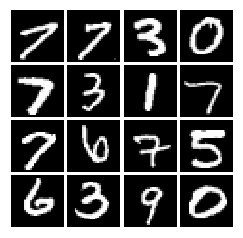

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## Random Noise

In [3]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    return tf.random_uniform([batch_size, dim], -1, 1)

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [4]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        x = tf.reshape(x, (tf.shape(x)[0], 28, 28, 1), name="reshape_3d")
        conv_1 = tf.layers.conv2d(x, filters=32, kernel_size=(5, 5), activation=tf.nn.leaky_relu, name="conv_1")
        pool_1 = tf.layers.max_pooling2d(conv_1, pool_size=(2, 2), strides=2, name="pool_1")
        conv_2 = tf.layers.conv2d(pool_1, filters=64, kernel_size=(5, 5), activation=tf.nn.leaky_relu, name="conv_2")
        pool_2 = tf.layers.max_pooling2d(conv_2, pool_size=(2, 2), strides=2, name="pool_2")
        fc_1 = tf.layers.conv2d(pool_2, filters=1024, kernel_size=(4, 4), name="fc_1", activation=tf.nn.leaky_relu)
        logits = tf.layers.conv2d(fc_1, filters=1, kernel_size=(1, 1), name="scores")
        return tf.reshape(logits, (-1, 1))

#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). 

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [5]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        fc1 = tf.layers.dense(z, 1024, tf.nn.relu)
        bn1 = tf.layers.batch_normalization(fc1)
        fc2 = tf.layers.dense(bn1, 7 * 7 * 128, tf.nn.relu)
        bn2 = tf.layers.batch_normalization(fc2)
        image_tensor = tf.reshape(bn2, (tf.shape(z)[0], 7, 7, 128))
        conv_T_1 = tf.layers.conv2d_transpose(image_tensor, filters=64, kernel_size=(4, 4), 
                                              strides=(2, 2), padding="same", activation=tf.nn.relu)
        bn3 = tf.layers.batch_normalization(conv_T_1)
        conv_T_2 = tf.layers.conv2d_transpose(bn3, filters=1, kernel_size=(4, 4), strides=(2, 2), 
                                               padding="same", activation=tf.nn.tanh)
        img = tf.reshape(conv_T_2, (-1,784))
    return img

# Least Squares GAN

The generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$

In [6]:
def lsgan_loss(scores_real, scores_fake):
    """Compute the GAN loss.
    
    Inputs:
    - scores_real: Tensor, shape [batch_size, 1], output of discriminator
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    
    D_loss = 0.5 * (tf.reduce_mean((scores_real - 1) ** 2) + tf.reduce_mean(scores_fake ** 2))
    G_loss = 0.5 * tf.reduce_mean((scores_fake - 1) ** 2)
    return D_loss, G_loss

# Optimizing our loss

In [7]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

    return D_solver, G_solver

# Training a GAN!

In [8]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

In [9]:
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(deprocess_img(samples[:16]))
            plt.show()
            print()
        # run a batch of data through the network
        minibatch_x, minibatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch_x})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(deprocess_img(samples[:16]))
    plt.show()

#### Train DCGAN! 

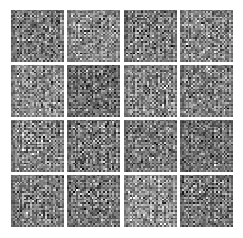


Iter: 0, D: 0.475, G:0.396
Iter: 50, D: 0.04478, G:0.388
Iter: 100, D: 0.05996, G:0.4209
Iter: 150, D: 0.04463, G:0.5478
Iter: 200, D: 0.0474, G:0.3205


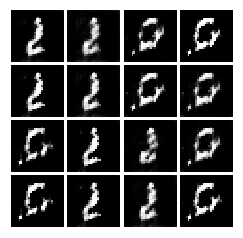


Iter: 250, D: 0.08399, G:0.3698
Iter: 300, D: 0.06564, G:0.4844
Iter: 350, D: 0.06636, G:0.5743
Iter: 400, D: 0.1637, G:0.4336
Iter: 450, D: 0.06036, G:0.3798


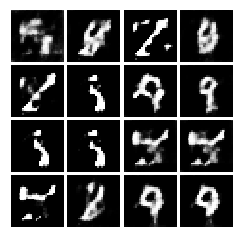


Iter: 500, D: 0.07414, G:0.3743
Iter: 550, D: 0.1352, G:0.346
Iter: 600, D: 0.07972, G:0.3453
Iter: 650, D: 0.09613, G:0.3924
Iter: 700, D: 0.1058, G:0.3477


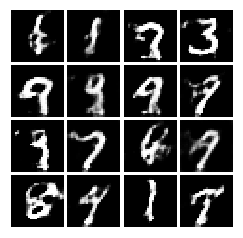


Iter: 750, D: 0.1598, G:0.2987
Iter: 800, D: 0.1483, G:0.2036
Iter: 850, D: 0.1292, G:0.252
Iter: 900, D: 0.1329, G:0.2776
Iter: 950, D: 0.1543, G:0.233


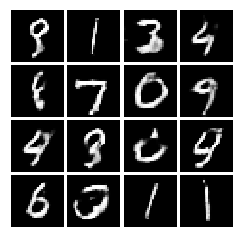


Iter: 1000, D: 0.1805, G:0.213
Iter: 1050, D: 0.1597, G:0.2359
Iter: 1100, D: 0.1695, G:0.2665
Iter: 1150, D: 0.1343, G:0.2946
Iter: 1200, D: 0.2419, G:0.1884


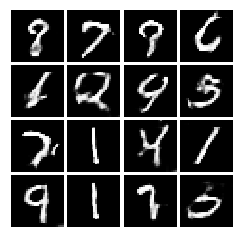


Iter: 1250, D: 0.1706, G:0.2171
Iter: 1300, D: 0.1664, G:0.2349
Iter: 1350, D: 0.1597, G:0.27
Iter: 1400, D: 0.1855, G:0.2872
Iter: 1450, D: 0.1885, G:0.2516


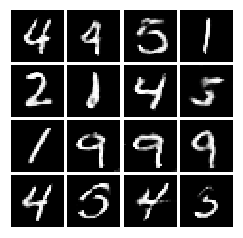


Iter: 1500, D: 0.2287, G:0.2229
Iter: 1550, D: 0.1706, G:0.2191
Iter: 1600, D: 0.1779, G:0.1992
Iter: 1650, D: 0.1786, G:0.1875
Iter: 1700, D: 0.2187, G:0.4005


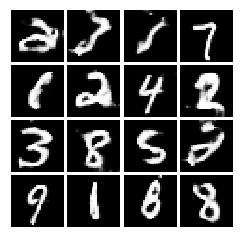


Iter: 1750, D: 0.2308, G:0.1561
Iter: 1800, D: 0.1843, G:0.2341
Iter: 1850, D: 0.1814, G:0.2613
Iter: 1900, D: 0.1884, G:0.2016
Iter: 1950, D: 0.1907, G:0.1873


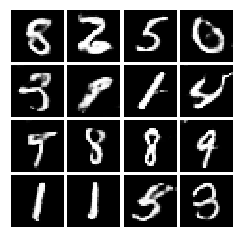


Iter: 2000, D: 0.1795, G:0.179
Iter: 2050, D: 0.2002, G:0.2732
Iter: 2100, D: 0.1759, G:0.2337
Iter: 2150, D: 0.2107, G:0.1622
Iter: 2200, D: 0.2164, G:0.2547


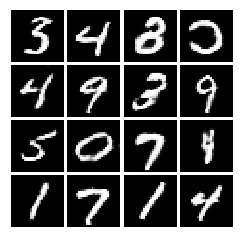


Iter: 2250, D: 0.217, G:0.2047
Iter: 2300, D: 0.1866, G:0.1529
Iter: 2350, D: 0.1557, G:0.2157
Iter: 2400, D: 0.2661, G:0.2049
Iter: 2450, D: 0.1819, G:0.2013


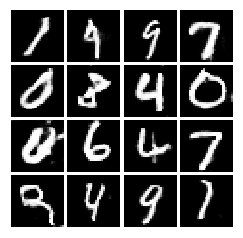


Iter: 2500, D: 0.1945, G:0.1812
Iter: 2550, D: 0.1795, G:0.2713
Iter: 2600, D: 0.1732, G:0.1512
Iter: 2650, D: 0.1857, G:0.2587
Iter: 2700, D: 0.2348, G:0.2188


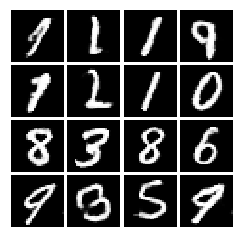


Iter: 2750, D: 0.1638, G:0.2006
Iter: 2800, D: 0.1589, G:0.2314
Iter: 2850, D: 0.1849, G:0.1939
Iter: 2900, D: 0.1884, G:0.1756
Iter: 2950, D: 0.181, G:0.2929


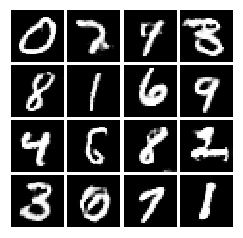


Iter: 3000, D: 0.1581, G:0.246
Iter: 3050, D: 0.168, G:0.2127
Iter: 3100, D: 0.2236, G:0.5147
Iter: 3150, D: 0.1689, G:0.1471
Iter: 3200, D: 0.1728, G:0.2581


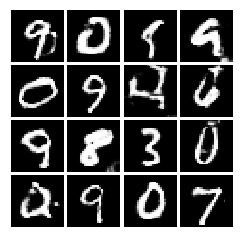


Iter: 3250, D: 0.1719, G:0.2105
Iter: 3300, D: 0.1761, G:0.2205
Iter: 3350, D: 0.1793, G:0.1926
Iter: 3400, D: 0.1603, G:0.2007
Iter: 3450, D: 0.1596, G:0.2695


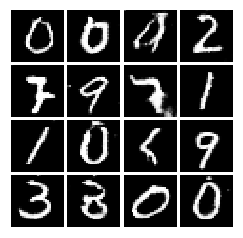


Iter: 3500, D: 0.1615, G:0.1971
Iter: 3550, D: 0.1509, G:0.246
Iter: 3600, D: 0.1555, G:0.288
Iter: 3650, D: 0.1728, G:0.2254
Iter: 3700, D: 0.1685, G:0.2007


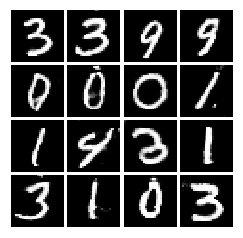


Iter: 3750, D: 0.1857, G:0.1746
Iter: 3800, D: 0.1869, G:0.1788
Iter: 3850, D: 0.1912, G:0.1602
Iter: 3900, D: 0.1585, G:0.247
Iter: 3950, D: 0.1604, G:0.2707


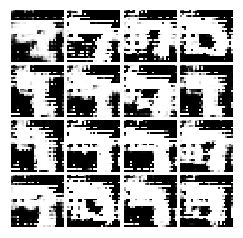


Iter: 4000, D: 0.05487, G:0.5148
Iter: 4050, D: 0.03032, G:0.5119
Iter: 4100, D: 0.04219, G:0.4512
Iter: 4150, D: 0.1032, G:0.323
Iter: 4200, D: 0.1453, G:0.2807


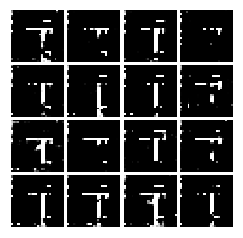


Iter: 4250, D: 0.1281, G:0.2612
Iter: 4300, D: 0.1004, G:0.3068
Iter: 4350, D: 0.1057, G:0.3311
Iter: 4400, D: 0.09607, G:0.3149
Iter: 4450, D: 0.09166, G:0.2976


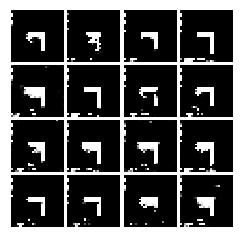


Iter: 4500, D: 0.06234, G:0.3674
Iter: 4550, D: 0.0422, G:0.4171
Iter: 4600, D: 0.03785, G:0.4217
Iter: 4650, D: 0.02935, G:0.4501
Iter: 4700, D: 0.04182, G:0.4403


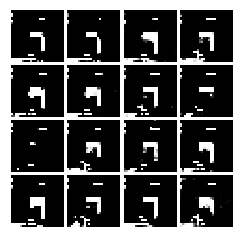


Iter: 4750, D: 0.03673, G:0.4095
Iter: 4800, D: 0.05198, G:0.3893
Iter: 4850, D: 0.04244, G:0.4239
Iter: 4900, D: 0.04503, G:0.431
Iter: 4950, D: 0.04234, G:0.4353


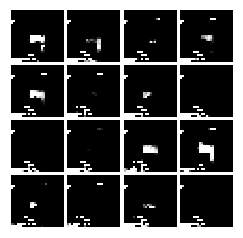


Iter: 5000, D: 0.03232, G:0.4568
Iter: 5050, D: 0.02909, G:0.4499
Iter: 5100, D: 0.02836, G:0.4512
Iter: 5150, D: 0.03025, G:0.4429
Iter: 5200, D: 0.02801, G:0.4486


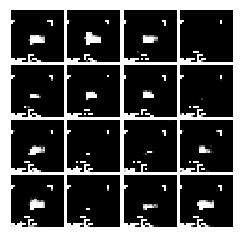


Iter: 5250, D: 0.02776, G:0.4547
Iter: 5300, D: 0.03133, G:0.4356
Iter: 5350, D: 0.04726, G:0.3903
Iter: 5400, D: 0.04483, G:0.3822
Iter: 5450, D: 0.04226, G:0.4116


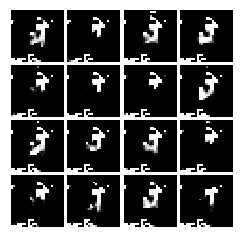


Iter: 5500, D: 0.04141, G:0.4145
Iter: 5550, D: 0.06236, G:0.3488
Iter: 5600, D: 0.05516, G:0.3705
Iter: 5650, D: 0.05883, G:0.3694
Iter: 5700, D: 0.05239, G:0.4061


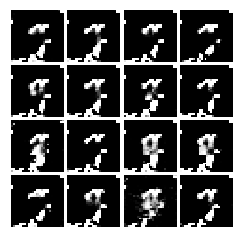


Iter: 5750, D: 0.0423, G:0.3943
Iter: 5800, D: 0.03969, G:0.4186
Iter: 5850, D: 0.04546, G:0.4073
Iter: 5900, D: 0.08338, G:0.33
Iter: 5950, D: 0.09797, G:0.2837


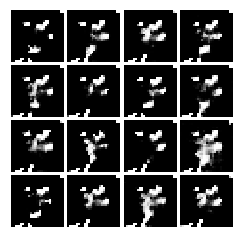


Iter: 6000, D: 0.0851, G:0.398
Iter: 6050, D: 0.05526, G:0.3922
Iter: 6100, D: 0.06618, G:0.2977
Iter: 6150, D: 0.07851, G:0.2818
Iter: 6200, D: 0.07289, G:0.3202


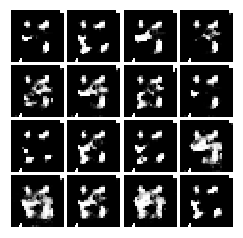


Iter: 6250, D: 0.05278, G:0.4346
Iter: 6300, D: 0.06429, G:0.3824
Iter: 6350, D: 0.1135, G:0.3877
Iter: 6400, D: 0.1571, G:0.2616
Iter: 6450, D: 0.1282, G:0.2536


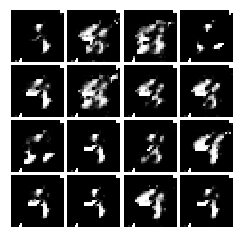


Iter: 6500, D: 0.09073, G:0.331
Iter: 6550, D: 0.2439, G:0.1896
Iter: 6600, D: 0.1304, G:0.2929
Iter: 6650, D: 0.1123, G:0.3539
Iter: 6700, D: 0.2669, G:0.1679


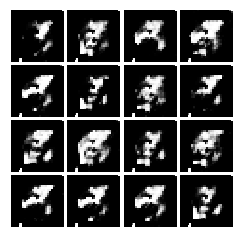


Iter: 6750, D: 0.2103, G:0.2084
Iter: 6800, D: 0.1474, G:0.25
Iter: 6850, D: 0.1778, G:0.2058
Iter: 6900, D: 0.1403, G:0.2601
Iter: 6950, D: 0.1928, G:0.2609


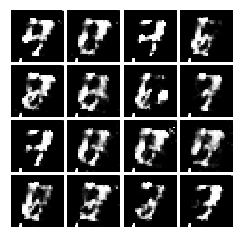


Iter: 7000, D: 0.1433, G:0.211
Iter: 7050, D: 0.1255, G:0.2909
Iter: 7100, D: 0.08797, G:0.4226
Iter: 7150, D: 0.1484, G:0.257
Iter: 7200, D: 0.1066, G:0.3566


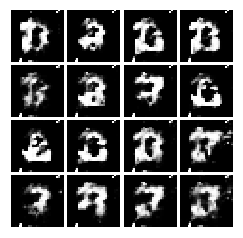


Iter: 7250, D: 0.1612, G:0.2283
Iter: 7300, D: 0.1514, G:0.2601
Iter: 7350, D: 0.2182, G:0.1799
Iter: 7400, D: 0.1725, G:0.1741
Iter: 7450, D: 0.1977, G:0.282


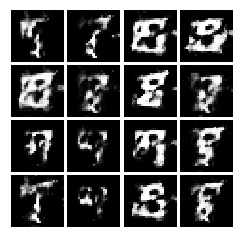


Iter: 7500, D: 0.2275, G:0.1249
Iter: 7550, D: 0.1769, G:0.2812
Iter: 7600, D: 0.1642, G:0.1958
Iter: 7650, D: 0.176, G:0.127
Iter: 7700, D: 0.1557, G:0.2248


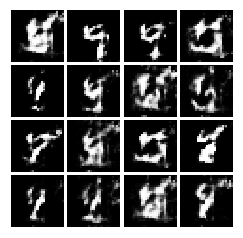


Iter: 7750, D: 0.1782, G:0.1801
Iter: 7800, D: 0.1891, G:0.216
Iter: 7850, D: 0.2068, G:0.131
Iter: 7900, D: 0.1736, G:0.2299
Iter: 7950, D: 0.2219, G:0.4756


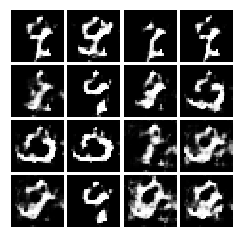


Iter: 8000, D: 0.2256, G:0.1215
Iter: 8050, D: 0.4153, G:0.04565
Iter: 8100, D: 0.1758, G:0.2404
Iter: 8150, D: 0.1777, G:0.2053
Iter: 8200, D: 0.1706, G:0.2417


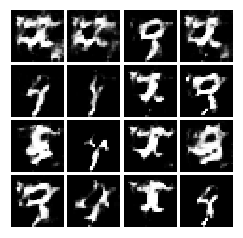


Iter: 8250, D: 0.1709, G:0.2195
Iter: 8300, D: 0.1414, G:0.2809
Iter: 8350, D: 0.2284, G:0.2164
Iter: 8400, D: 0.2561, G:0.1693
Iter: 8450, D: 0.1536, G:0.2325


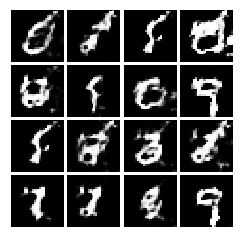


Iter: 8500, D: 0.2833, G:0.4155
Iter: 8550, D: 0.1691, G:0.2456
Final images


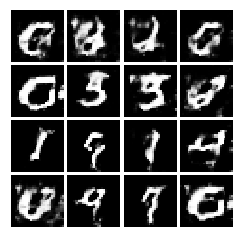

In [10]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step, num_epoch=20)

## Conclusion

The results are fascinating. We had very sharp images after the iteration $3700$. But After that generator goes hay-wire. It is generating images that doesn't resembles the digits. So the generator loss increases but it is good to see that the generator was able to learn from these mistakes and able to give slightly better images at the end.

** Why does this happen?**

